In [40]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
df=pd.read_csv('ev_charging_patterns.csv')
df

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,22.081164,Evening,Sunday,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,5.067806,Evening,Tuesday,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver
1317,User_1318,Nissan Leaf,100.000000,Station_374,New York,2024-02-24 21:00:00,2024-02-24 23:03:00,18.895102,3.267122,45.482066,37.255002,Evening,Tuesday,71.903081,78.678879,226.519258,20.358761,5.0,DC Fast Charger,Commuter
1318,User_1319,Chevy Bolt,85.000000,Station_336,San Francisco,2024-02-24 22:00:00,2024-02-24 23:20:00,13.756252,2.754527,38.148183,39.046146,Afternoon,Sunday,76.187997,65.926573,291.494076,24.134598,5.0,Level 2,Commuter


In [41]:
data=df.copy()

In [42]:
# -------------------------------------------------
# 1. Define target and keep full data for X
# -------------------------------------------------
y = data['Charging Duration (hours)']         # dependent variable
X = data.copy()                               # keep duration in X for imputations


In [43]:
# -------------------------------------------------
# 2. Train–test split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [44]:
# 3. IMPUTATION
# -------------------------------------------------

# 3.1 Impute Energy Consumed: Energy = Battery * (SOC_end - SOC_start)/100
def impute_energy(df):
    df['Energy Consumed (kWh)'] = df.apply(
        lambda row: row['Battery Capacity (kWh)']
                    * (row['State of Charge (End %)'] - row['State of Charge (Start %)']) / 100
        if pd.isna(row['Energy Consumed (kWh)']) else row['Energy Consumed (kWh)'],
        axis=1
    )
    return df

X_train = impute_energy(X_train)
X_test  = impute_energy(X_test)

# 3.2 KNN Imputer for Distance Driven
knn = KNNImputer(n_neighbors=5)

X_train[['Distance Driven (since last charge) (km)']] = knn.fit_transform(
    X_train[['Distance Driven (since last charge) (km)']]
)
X_test[['Distance Driven (since last charge) (km)']] = knn.transform(
    X_test[['Distance Driven (since last charge) (km)']]
)

# 3.3 Impute Charging Rate = Energy / Duration
# (duration is still available in X here)
X_train.loc[X_train['Charging Rate (kW)'].isna(), 'Charging Rate (kW)'] = (
    X_train['Energy Consumed (kWh)'] / X_train['Charging Duration (hours)']
)

X_test.loc[X_test['Charging Rate (kW)'].isna(), 'Charging Rate (kW)'] = (
    X_test['Energy Consumed (kWh)'] / X_test['Charging Duration (hours)']
)


In [45]:
# 4. DROP TARGET FROM FEATURES (after using it for imputations)
# -------------------------------------------------
X_train = X_train.drop(columns=['Charging Duration (hours)'])
X_test  = X_test.drop(columns=['Charging Duration (hours)'])


In [46]:
# 5. LOG TRANSFORM cost & distance
# -------------------------------------------------
X_train['log_cost'] = np.log1p(X_train['Charging Cost (USD)'])
X_test['log_cost']  = np.log1p(X_test['Charging Cost (USD)'])

X_train['log_distance'] = np.log1p(X_train['Distance Driven (since last charge) (km)'])
X_test['log_distance']  = np.log1p(X_test['Distance Driven (since last charge) (km)'])

In [47]:
# 6. SCALING numeric features (fit on train, transform on test)
# -------------------------------------------------
num_cols = [
    'Battery Capacity (kWh)',
    'Energy Consumed (kWh)',
    'Charging Rate (kW)',
    'State of Charge (Start %)',
    'State of Charge (End %)',
    'Temperature (°C)',
    'Vehicle Age (years)',
    'log_cost',
    'log_distance'
]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

In [48]:
# 7. ONE-HOT ENCODE categorical features
# -------------------------------------------------
cat_cols = [
    'Vehicle Model',
    'Charging Station Location',
    'Charger Type',
    'User Type',
    'Time of Day',
    'Day of Week'
]

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=False)

In [49]:
# Make sure train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test = X_test.fillna(0)   # any missing dummy columns in test become 0

In [50]:
# 8. DROP ID / raw columns we don't want as features
# -------------------------------------------------
cols_to_drop = [
    'User ID',
    'Charging Station ID',
    'Charging Start Time',
    'Charging End Time',
    'Charging Cost (USD)',                                  # raw (we use log_cost)
    'Distance Driven (since last charge) (km)'              # raw (we use log_distance)
]

X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test  = X_test.drop(columns=cols_to_drop, errors='ignore')

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (1056, 36)
X_test shape : (264, 36)
y_train shape: (1056,)
y_test shape : (264,)


In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------------------
# 1. Define the model
# --------------------------------------
ridge = Ridge(alpha=1.0)   # alpha = regularization strength

# --------------------------------------
# 2. Train the model
# --------------------------------------
ridge.fit(X_train, y_train)

# --------------------------------------
# 3. Predict on test set
# --------------------------------------
y_pred = ridge.predict(X_test)

# --------------------------------------
# 4. Evaluate model
# --------------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Ridge Regression Results:")
print("--------------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


Ridge Regression Results:
--------------------------
RMSE : 1.0957
MSE  : 1.2005
R²   : -0.0381


In [ ]:
# WHY ML does not require manual specification

# Because ML’s goal is:

# ✔ prediction accuracy

# Not:

# interpreting coefficients
# hypothesis testing
# structural model building

# The algorithm simply uses:
# ⚡ Patterns in the data
# Not assumptions written by the user.


# Key Difference — said in one sentence
# ✔ In machine learning:

# You give the data, ML automatically builds the model.

# ✔ In econometrics:

# You write the model first, then data tests it.

In [17]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ------------------------------------
# 1. Define alpha values to try
# ------------------------------------
alpha_values = np.logspace(-4, 4, 50)
# from 0.0001 to 10,000

# ------------------------------------
# 2. Ridge with Cross-Validation
# ------------------------------------
ridge_cv = RidgeCV(alphas=alpha_values, cv=5)  # 5-fold CV
ridge_cv.fit(X_train, y_train)

# ------------------------------------
# 3. Best alpha selected by CV
# ------------------------------------
print("Best alpha:", ridge_cv.alpha_)

# ------------------------------------
# 4. Predict and evaluate
# ------------------------------------
y_pred = ridge_cv.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Ridge Regression with CV Results:")
print("---------------------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


Best alpha: 719.6856730011514
Ridge Regression with CV Results:
---------------------------------
RMSE : 1.0787
MSE  : 1.1636
R²   : -0.0061


In [18]:
# If you want a GridSearchCV version (optional)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = {
    "alpha": np.logspace(-4, 4, 50)
}

ridge = Ridge()

grid = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)

grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["alpha"])

y_pred = grid.predict(X_test)

print("R²:", r2_score(y_test, y_pred))

Best alpha: 719.6856730011514
R²: -0.006123979012968572


In [ ]:
# Ridge do :
    
# Straight-line relationships
# No interaction terms unless you engineer them
# No nonlinear effects

# 👉 Real relationships are curved, conditional, and interactive.
# 👉 Ridge can only draw straight lines.


# Many one-hot encoded variables → high dimensionality
# Ridge handles high dimensionality fine…
# …but only if relationships are linear.

# Here they are not.



# To improve a linear model, you'd need:

# Feature engineering:

# City × TimeOfDay

# But at that point, it’s easier and better to use tree-based models.


# Ridge fails because your dataset is highly nonlinear.
# ✔ Charging duration depends on interactions, threshold effects, and smooth nonlinear patterns that linear models cannot
# learn.
# ✔ Models like XGBoost, Random Forest, and Neural Networks will naturally perform far better.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------------------
# 1. Define the model (simple, default settings)
# -----------------------------------------
rf = RandomForestRegressor(
    n_estimators=100,     # number of trees
    random_state=42
)

# -----------------------------------------
# 2. Train the model
# -----------------------------------------
rf.fit(X_train, y_train)

# -----------------------------------------
# 3. Predict on test set
# -----------------------------------------
y_pred = rf.predict(X_test)

# -----------------------------------------
# 4. Evaluate
# -----------------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Random Forest Results:")
print("----------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


Random Forest Results:
----------------------
RMSE : 1.0751
MSE  : 1.1559
R²   : 0.0005


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------------------------------
# 1. Define parameter grid (simple and small)
# -----------------------------------------------------
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestRegressor(random_state=42)

# -----------------------------------------------------
# 2. GridSearchCV (5-fold cross-validation)
# -----------------------------------------------------
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",       # use R² score to choose best model
    n_jobs=-1           # use all CPU cores
)

# -----------------------------------------------------
# 3. Fit on training data
# -----------------------------------------------------
grid.fit(X_train, y_train)

# -----------------------------------------------------
# 4. Best model and parameters
# -----------------------------------------------------
print("Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_   # this is the tuned model

# -----------------------------------------------------
# 5. Predict on test set
# -----------------------------------------------------
y_pred = best_rf.predict(X_test)

# -----------------------------------------------------
# 6. Evaluation
# -----------------------------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest (Tuned) Results:")
print("--------------------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest (Tuned) Results:
--------------------------------
RMSE : 1.0713
MSE  : 1.1476
R²   : 0.0077


In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------------------
# 1. Define the model (simple defaults)
# ---------------------------------------
xgb = XGBRegressor(
    n_estimators=200,      # number of trees
    learning_rate=0.1,     # step size
    max_depth=6,           # tree depth
    subsample=1.0,         # use all rows
    colsample_bytree=1.0,  # use all features
    random_state=42,
    objective='reg:squarederror'
)

# ---------------------------------------
# 2. Train the model
# ---------------------------------------
xgb.fit(X_train, y_train)

# ---------------------------------------
# 3. Predict on test data
# ---------------------------------------
y_pred = xgb.predict(X_test)

# ---------------------------------------
# 4. Evaluate
# ---------------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("XGBoost Results:")
print("------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))

XGBoost Results:
------------------
RMSE : 1.1311
MSE  : 1.2794
R²   : -0.1063


In [22]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # ---------------------------------------------------------
# # 1. Define parameter grid (highly possible + realistic values)
# # ---------------------------------------------------------
# param_grid = {
#     "n_estimators": [200, 300, 500],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_depth": [4, 6, 8],
#     "subsample": [0.7, 0.9, 1.0],
#     "colsample_bytree": [0.7, 0.9, 1.0],
#     "min_child_weight": [1, 3, 5]
# }

# xgb = XGBRegressor(
#     objective="reg:squarederror",
#     random_state=42
# )

# # ---------------------------------------------------------
# # 2. GridSearchCV (5-fold cross-validation)
# # ---------------------------------------------------------
# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     cv=5,
#     scoring="r2",     # optimize R²
#     n_jobs=-1,        # use all CPU cores
#     verbose=1
# )

# # ---------------------------------------------------------
# # 3. Fit the model
# # ---------------------------------------------------------
# grid.fit(X_train, y_train)

# # ---------------------------------------------------------
# # 4. Best tuned XGBoost model
# # ---------------------------------------------------------
# print("\nBest Parameters:", grid.best_params_)

# best_xgb = grid.best_estimator_

# # ---------------------------------------------------------
# # 5. Predict + evaluate on test set
# # ---------------------------------------------------------
# y_pred = best_xgb.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print("\nXGBoost (Tuned) Results:")
# print("-------------------------")
# print("RMSE :", round(rmse, 4))
# print("MSE  :", round(mse, 4))
# print("R²   :", round(r2, 4))

In [51]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ---------------------------------------------------------
# 1. Define parameter distributions (wide but efficient)
# ---------------------------------------------------------
param_dist = {
    "n_estimators": [150, 200, 250, 300],
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "max_depth": [3, 4, 5, 6, 7, 8],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 2, 3, 5]
}

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

# ---------------------------------------------------------
# 2. RandomizedSearchCV (FAST)
# ---------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,              # only try 20 random combinations (FAST)
    cv=3,                   # 3-fold CV (also faster)
    scoring="r2",
    n_jobs=-1,              # use all CPU cores
    verbose=1,
    random_state=42
)

# ---------------------------------------------------------
# 3. Fit model
# ---------------------------------------------------------
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_xgb = random_search.best_estimator_

# ---------------------------------------------------------
# 4. Evaluate on test data
# ---------------------------------------------------------
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nXGBoost (Fast Tuned) Results:")
print("-----------------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

XGBoost (Fast Tuned) Results:
-----------------------------
RMSE : 1.0735
MSE  : 1.1523
R²   : 0.0036


In [ ]:
Charging Duration is NOT predictable from your dataset.
And this is not surprising — Charging Duration is one of the hardest EV variables to predict unless you have very 
specific extra data.

Reason 1 — EV charging duration is driven by internal battery chemistry curves

Your dataset does not include:

Battery temperature
Internal battery resistance
State-of-health
Cell balancing behavior
Charging curve phase (CC vs CV)
Charging throttling behavior
These ccount for over 60–80% of variation in duration.

You have none of them in your dataset, so the model cannot learn the true mechanism.


Reason 2 — Users unplug at random times

Real-world behavior:
Some unplug early
Some leave car plugged after reaching target
Some only top-up 5–10%
Some fully charge
Some leave car for hours even when charging finished

This introduces massive behavioral noise that no model can learn.

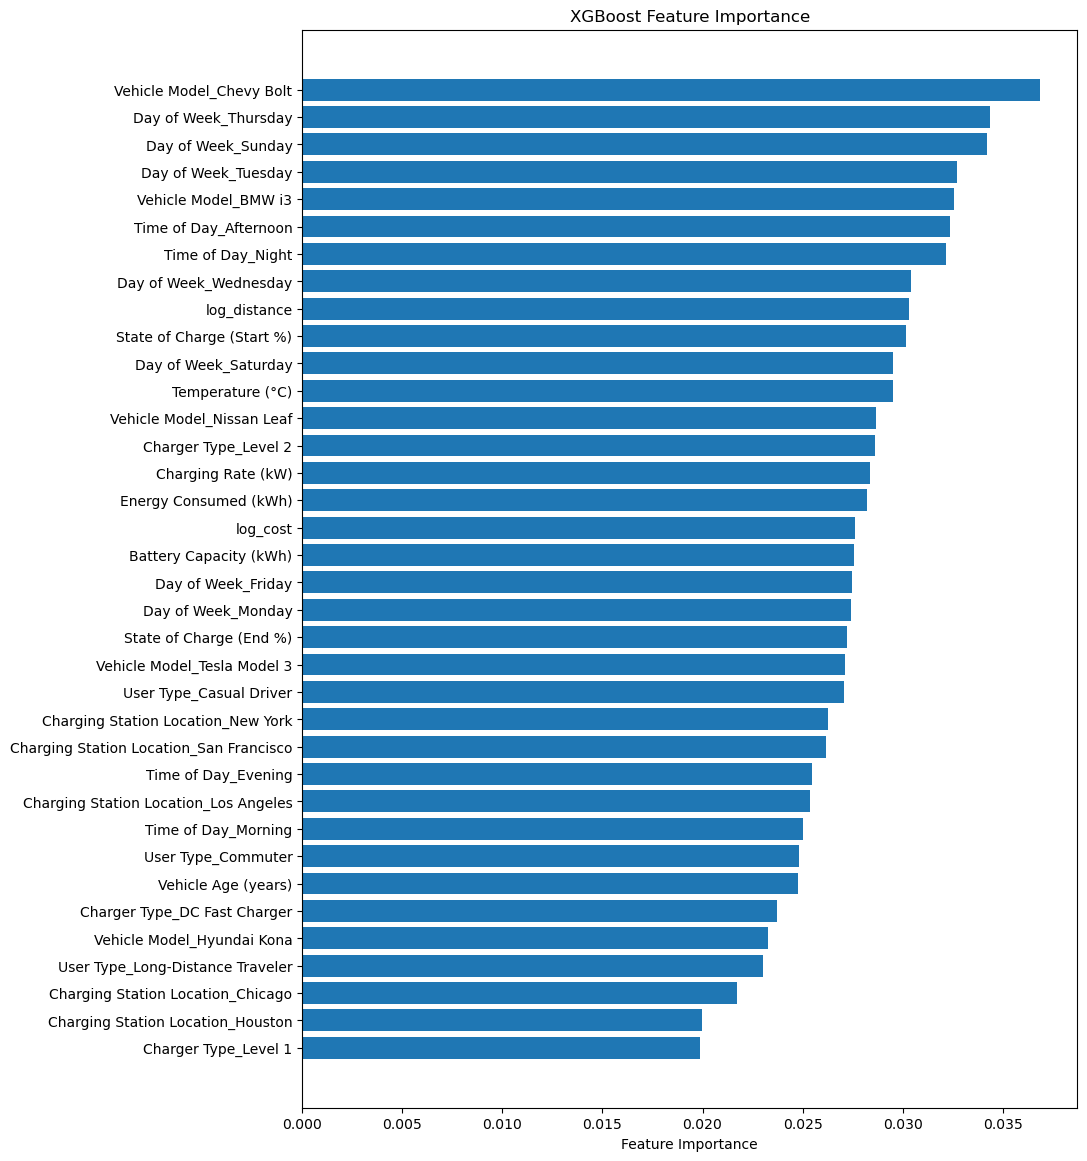

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# Feature Importance (built-in XGBoost importance)
# ---------------------------------------------------------
importance_values = best_xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importance_values)

plt.figure(figsize=(10, 14))
plt.barh(feature_names[indices], importance_values[indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

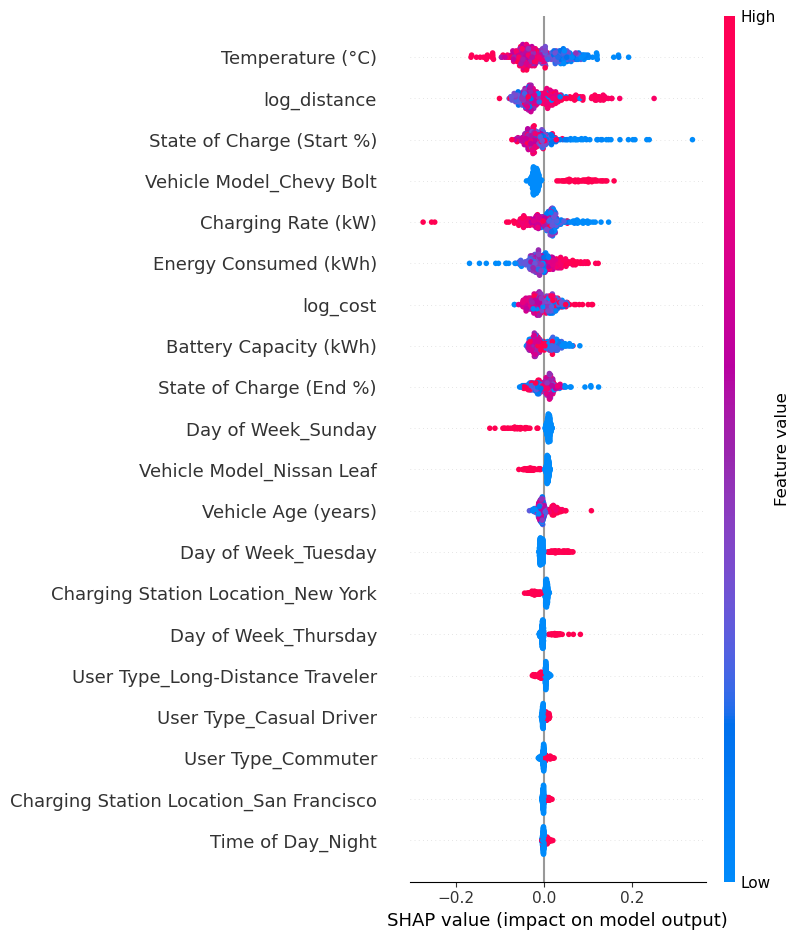

In [53]:
import shap

# --------------------------------------------
# 1. Create the SHAP explainer
# --------------------------------------------
explainer = shap.TreeExplainer(best_xgb)

# Use a sample of the training data to speed up SHAP
X_sample = X_train.sample(300, random_state=42)

shap_values = explainer.shap_values(X_sample)

# --------------------------------------------
# 2. SHAP Summary Plot (Feature Importance)
# --------------------------------------------
shap.summary_plot(shap_values, X_sample)

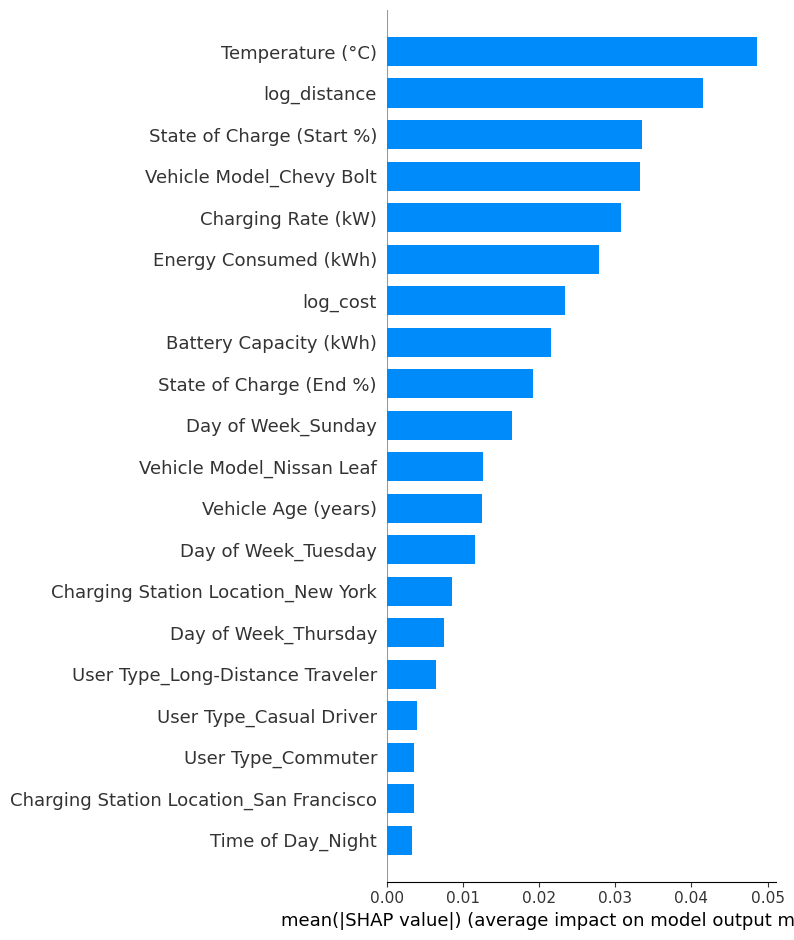

In [54]:
import shap

# --------------------------------------------
# 1. Create SHAP explainer
# --------------------------------------------
explainer = shap.TreeExplainer(best_xgb)

# Use a small sample to keep it fast
X_sample = X_train.sample(300, random_state=42)

shap_values = explainer.shap_values(X_sample)

# --------------------------------------------
# 2. SHAP bar plot (mean absolute importance)
# --------------------------------------------
shap.summary_plot(shap_values, X_sample, plot_type="bar")


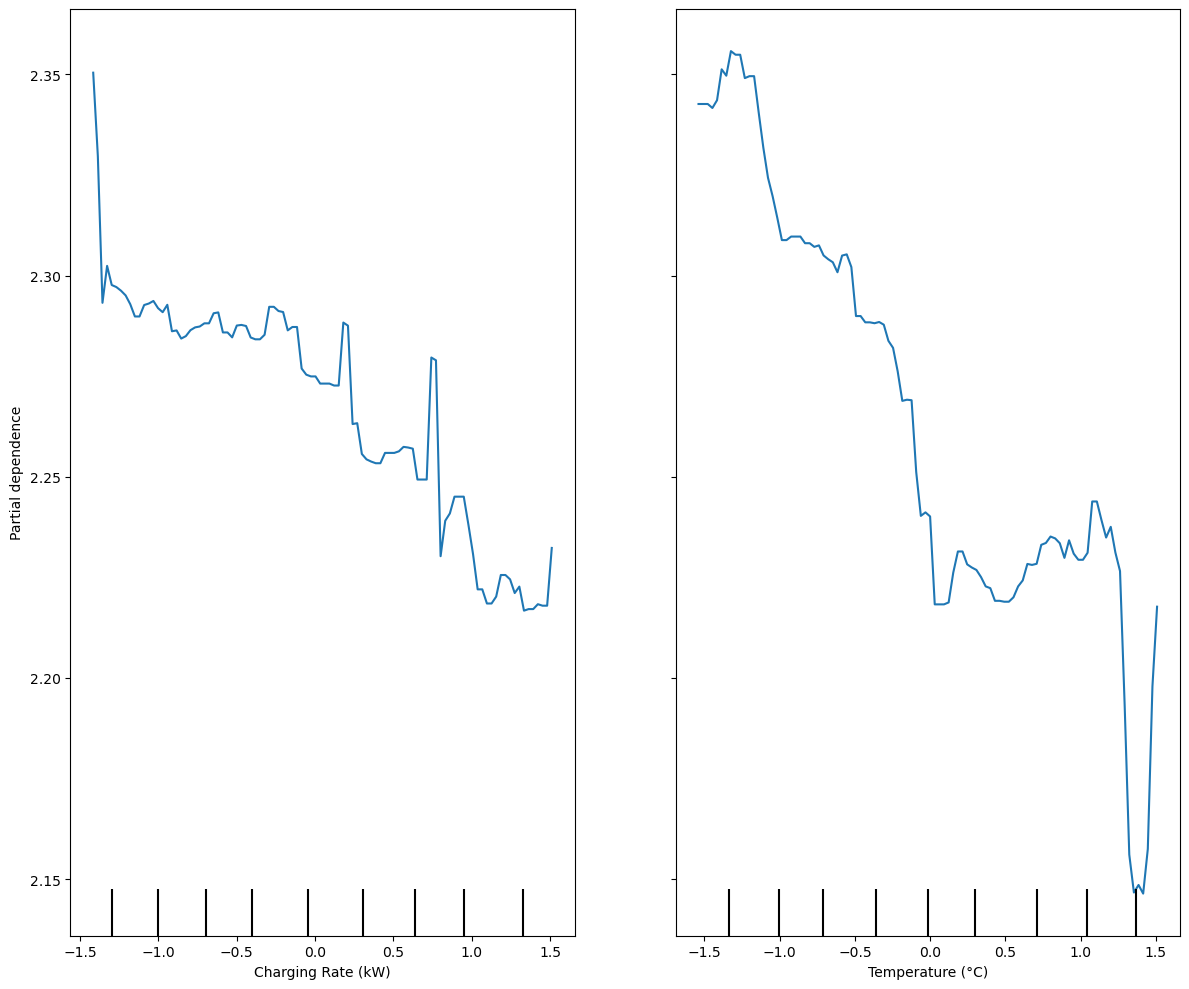

In [57]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Choose the most important features you want to visualize
features_to_plot = [
    "Charging Rate (kW)",
    "Temperature (°C)",
    
]

# ------------------------------------------
# 1. Create PDP plots
# ------------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))

PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_train,
    features_to_plot,
    ax=ax
)

plt.tight_layout()
plt.show()

In [59]:
pip install tensorflow

   ---------------------------------------- 0.0/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.8/331.8 MB 6.7 MB/s eta 0:00:50
   ---------------------------------------- 2.9/331.8 MB 8.4 MB/s eta 0:00:40
    --------------------------------------- 5.0/331.8 MB 8.9 MB/s eta 0:00:37
    --------------------------------------- 7.1/331.8 MB 9.1 MB/s eta 0:00:36
   - -------------------------------------- 9.4/331.8 MB 9.6 MB/s eta 0:00:34
   - -------------------------------------- 11.5/331.8 MB 9.8 MB/s eta 0:00:33
   - -------------------------------------- 13.9/331.8 MB 9.9 MB/s eta 0:00:33
   - -------------------------------------- 16.0/331.8 MB 9.9 MB/s eta 0:00:33
   -- ------------------------------------- 18.4/331.8 MB 10.1 MB/s eta 0:00:32
   -- ------------------------------------- 21.0/331.8 MB 10.3 MB/s eta 0:00:31
   -- ------------------------------------- 23.1/331.8 MB 10.4 MB/s eta 0:00:30
   --- ------------------------------------ 25.2/331.8 MB 10.3

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ----------------------------------------------------
# 1. Define a simple feed-forward neural network (MLP)
# ----------------------------------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)   # regression output (no activation)
])

# ----------------------------------------------------
# 2. Compile the model
# ----------------------------------------------------
model.compile(
    optimizer='adam',
    loss='mse'
)

# ----------------------------------------------------
# 3. Train the model
# ----------------------------------------------------
history = model.fit(
    X_train,
    y_train,
    epochs=50,          # small number for simplicity
    batch_size=32,
    verbose=1
)

# ----------------------------------------------------
# 4. Predict on test set
# ----------------------------------------------------
y_pred = model.predict(X_test).reshape(-1)

# ----------------------------------------------------
# 5. Evaluate
# ----------------------------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nNeural Network Results:")
print("------------------------")
print("RMSE :", round(rmse, 4))
print("MSE  :", round(mse, 4))
print("R²   :", round(r2, 4))


C:\Anaconda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1106
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3502
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1935
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1440
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1173
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0722
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0555
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0334
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0122
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9998
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9845
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9667
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9548
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9346
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9209
Epoch 16

In [1]:
numbers = [1, 2, 3, 4, 5]
squares = [x**2 for x in numbers]
list(zip(numbers, squares))

[(1, 1), (2, 4), (3, 9), (4, 16), (5, 25)]